In [1]:
from numba import cuda
from matplotlib import pyplot as plt
from math import floor
import numpy as np
import time

In [2]:
if cuda.is_available(): # List devices
    devices = cuda.list_devices()
    print("GPU devices:")
    for device in devices:
        print("-", device.name)
    print("Selected device:", cuda.get_current_device().name)

GPU devices:
- b'NVIDIA GeForce RTX 3060 Laptop GPU'
Selected device: b'NVIDIA GeForce RTX 3060 Laptop GPU'


In [31]:
# 1ST XP : Incrementation of an array

GRID_SIZE = 100 # Number of blocks in the grid
BLOCKSIZE = 100 # Number of threads for each block

In [4]:
@cuda.jit # Indicate to Python that this function is a CUDA Kernel
def cudakernel0(array):
    thread_position = cuda.grid(1)
    array[thread_position] += 1

In [5]:
def CPUkernel0(array):
    for i in range(array.size):
        array[i] += 1

Icrementation of array by 1 | size: 10000
Kernel launch: cudakernel0[ 100 ,  100 ](array)... Success
CPU launch... Success
GPU time: 0.001999378204345703
CPU time: 0.017009258270263672


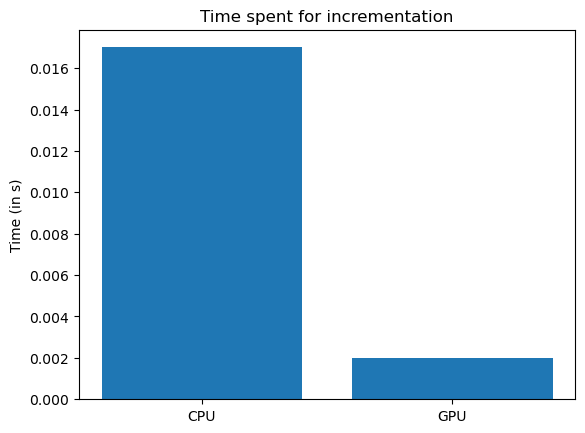

In [33]:
array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)

print("Icrementation of array by 1 | size:", GRID_SIZE*BLOCKSIZE)

# GPU
print('Kernel launch: cudakernel0[', GRID_SIZE, ', ', BLOCKSIZE,'](array)...', end=" ")
start = time.time()
cudakernel0[GRID_SIZE, BLOCKSIZE](array)
GPU_time = time.time() - start
print("Success")

# CPU
array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
print('CPU launch...', end=" ")
start = time.time()
CPUkernel0(array)
CPU_time = time.time() - start
print("Success")
      
print("GPU time:", GPU_time)
print("CPU time:", CPU_time)


fig,ax = plt.subplots(1)
ax.bar([0, 1], [CPU_time, GPU_time], tick_label=["CPU", "GPU"])
ax.set_ylabel("Time (in s)")
plt.title("Time spent for incrementation")
plt.show()


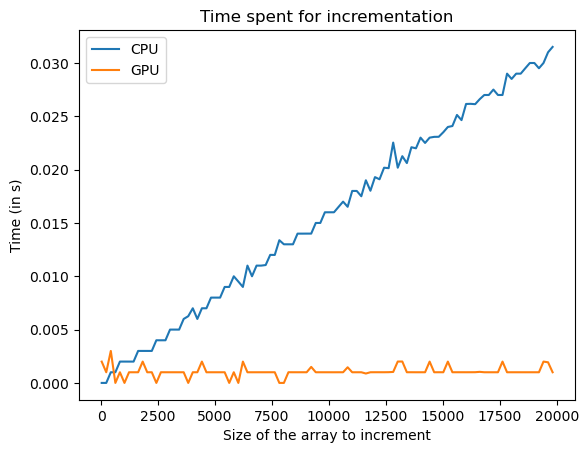

In [35]:
#Same xp as a function of the number of operations

operations = np.array([1 + i * 10 for i in range(0, 100)])
size_op = operations.size
BLOCKSIZE = 20

times = np.zeros((2, size_op))

for i in range(size_op):
    GRID_SIZE = operations[i]
    
    array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
    
    # GPU
    start = time.time()
    cudakernel0[GRID_SIZE, BLOCKSIZE](array)
    GPU_time = time.time() - start

    # CPU
    array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
    start = time.time()
    CPUkernel0(array)
    CPU_time = time.time() - start
    
    times[0, i] = CPU_time
    times[1, i] = GPU_time

plt.title("Time spent for incrementation")
plt.plot(operations * BLOCKSIZE, times[0], label = 'CPU')
plt.plot(operations * BLOCKSIZE, times[1], label = 'GPU')
plt.ylabel("Time (in s)")
plt.xlabel("Size of the array to increment")
plt.legend()
plt.show()

In [51]:
# 2ND XP : Matrix multiplication

GRID_SIZE = 50 # Number of blocks in the grid
BLOCKSIZE = 50 # Number of threads for each block

In [46]:
@cuda.jit
def cudakernel1(matrix1, matrix2, res, blocksize):
    pos = cuda.grid(1)
    block_position = (int)(pos / blocksize)
    thread_position = pos % blocksize
    
    result = 0
        
    for i in range(blocksize):
        result += matrix1[block_position, i] * matrix2[i, thread_position]
    
    res[block_position, thread_position] = result
    

In [42]:
def CPUkernelNumpy(matrix1, matrix2):
    return np.dot(matrix1, matrix2)

In [41]:
def CPUkernel1(matrix1, matrix2, blocksize, gridsize):
    res = np.zeros((gridsize, blocksize), np.float32)

    for i in range(gridsize):
        for j in range(blocksize):
            result = 0
            for k in range(blocksize):
                result += matrix1[i, k] * matrix2[k, j]
            res[i, j] = result
            
    return res

Matrix multiplication, | matrix size: (50, 50)
Kernel launch: cudakernel1[ 50 ,  50 ](array)... Success
CPU launch... Success
GPU time: 0.002001047134399414
CPU time: 0.033483028411865234


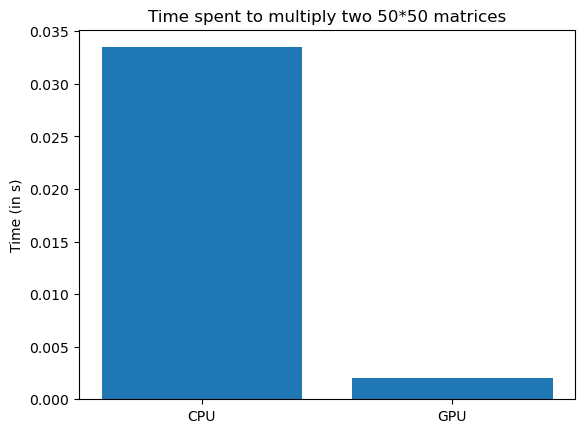

In [54]:
matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)

print("Matrix multiplication, | matrix size:", matrix1.shape)

# GPU
print('Kernel launch: cudakernel1[', GRID_SIZE, ', ', BLOCKSIZE,'](array)...', end=" ")
start = time.time()
cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
GPU_time = time.time() - start
print("Success")

# CPU
array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
print('CPU launch...', end=" ")
start = time.time()
res = CPUkernel1(matrix1, matrix2, BLOCKSIZE, GRID_SIZE)
CPU_time = time.time() - start
print("Success")
      
print("GPU time:", GPU_time)
print("CPU time:", CPU_time)

fig,ax = plt.subplots(1)
ax.bar([0, 1], [CPU_time, GPU_time], tick_label=["CPU", "GPU"])
ax.set_ylabel("Time (in s)")
plt.title("Time spent to multiply two 50*50 matrices")
plt.show()

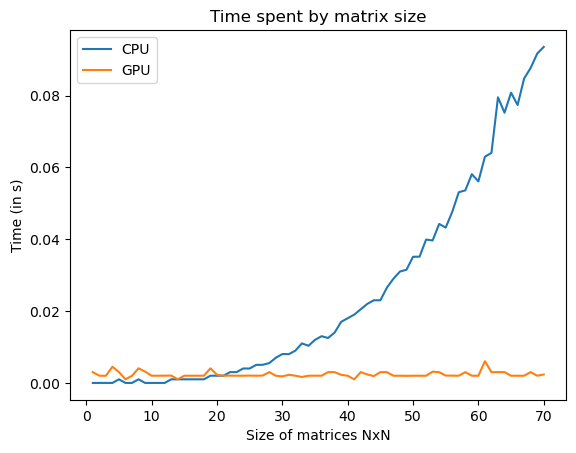

In [15]:
# Same xp as a function of the number of operations

operations = np.array([1 + i for i in range(0, 70)])
size_op = operations.size

times = np.zeros((2, size_op))

for i in range(size_op):
    GRID_SIZE = operations[i]
    BLOCKSIZE = operations[i]
    
    matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
    matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

    res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)

    # GPU
    start = time.time()
    cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
    GPU_time = time.time() - start
    
    # CPU
    array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
    start = time.time()
    res = CPUkernel1(matrix1, matrix2, GRID_SIZE, BLOCKSIZE)
    CPU_time = time.time() - start
    
    times[0, i] = CPU_time
    times[1, i] = GPU_time

plt.title("Time spent by matrix size")
plt.plot(operations, times[0], label = 'CPU')
plt.plot(operations, times[1], label = 'GPU')
plt.ylabel("Time (in s)")
plt.xlabel("Size of matrices NxN")
plt.legend()
plt.show()

Matrix multiplication, | matrix size: (70, 1024)
Kernel launch: cudakernel1[ 70 ,  1024 ](array)... Success
CPU numpy launch... Success
GPU time: 0.036985158920288086
CPU numpy time: 0.0020008087158203125


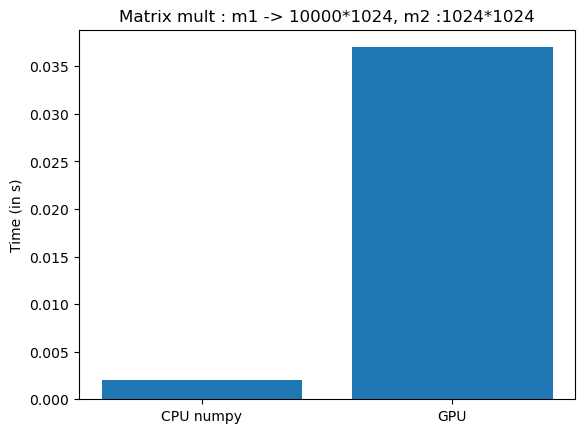

In [23]:
matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)

print("Matrix multiplication, | matrix size:", matrix1.shape)

# GPU
print('Kernel launch: cudakernel1[', GRID_SIZE, ', ', BLOCKSIZE,'](array)...', end=" ")
start = time.time()
cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
GPU_time = time.time() - start
print("Success")

# CPU Numpy
array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
print('CPU numpy launch...', end=" ")
start = time.time()
res = CPUkernelNumpy(matrix1, matrix2)
CPU_numpy_time = time.time() - start
print("Success")
      
print("GPU time:", GPU_time)
print("CPU numpy time:", CPU_numpy_time)
      
fig,ax = plt.subplots(1)
ax.bar([0, 1], [CPU_numpy_time, GPU_time], tick_label=["CPU numpy", "GPU"])
ax.set_ylabel("Time (in s)")
plt.title("Matrix mult : m1 -> 10000*1024")
plt.show()

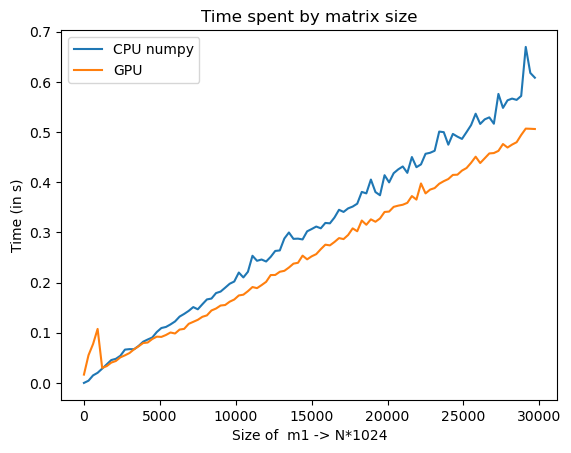

In [26]:
# Same xp as a function of the number of operations

operations = np.array([1 + i * 300 for i in range(0, 100)])
size_op = operations.size

times = np.zeros((2, size_op))

BLOCKSIZE = 1024

for i in range(size_op):
    GRID_SIZE = operations[i]
    
    matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
    matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

    res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)


    # GPU
    start = time.time()
    cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
    GPU_time = time.time() - start

    # CPU Numpy
    array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
    start = time.time()
    res = CPUkernelNumpy(matrix1, matrix2)
    CPU_numpy_time = time.time() - start
    
    times[0, i] = CPU_numpy_time
    times[1, i] = GPU_time

plt.title("Time spent by matrix size")
plt.plot(operations, times[0], label = 'CPU numpy')
plt.plot(operations, times[1], label = 'GPU')
plt.ylabel("Time (in s)")
plt.xlabel("Size of  m1 -> N*1024")
plt.legend()
plt.show()